# Librerias y funciones auxiliares

In [1]:
# Importar csv y tratar con el dataset
import pandas as pd
# NLP
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('word2vec_sample')
# Eliminar warning del replace
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Detectar emojis y filtrarlos
import emoji
# from enum import Enum
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
# Graficar
import matplotlib.pyplot as plt
# Guardado e importacion
import joblib
# Traducir
from googletrans import Translator
# Progreso
from tqdm import tqdm


from enum import Enum


# Funcion axuiliar para saber si estoy en el collab y usar su path o el del proyecto de github
def is_running_on_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False
    
# Funcion auxiliar para luego entrenar varios modelos con una sola ejecucion
class Modelos(Enum):
    LOGISTIC_REGRESSION = 'logistic_regression'
    DECISION_TREE = 'decision_tree'
    MULTINOMIAL = 'multinomial'
    BERNOULLI = 'bernoulli'
    GAUSIAN = 'gausian'

def select_model_to_train(model_name):
    models = {
        Modelos.LOGISTIC_REGRESSION.value: LogisticRegression(max_iter=1000),
        Modelos.DECISION_TREE.value : DecisionTreeClassifier(),
        Modelos.MULTINOMIAL.value : MultinomialNB(),
        Modelos.BERNOULLI.value: BernoulliNB(),
        Modelos.GAUSIAN.value: GaussianNB()
    }
    if model_name in models:
        return models[model_name]
    else:
        raise ValueError(f"Modelo '{model_name}' no válido")
    

def show_dataset_info(df, nombre_columna):
    print("Cantidad de registros:")
    print(len(df))

    print("Contenido:")
    print(df.head())

    conteo_valores = df[nombre_columna].value_counts()
    porcentaje_valores = conteo_valores / len(df) * 100


    for index, value in enumerate(conteo_valores):
        porcentaje = porcentaje_valores.iloc[index]
        plt.text(index, value + 0.5, '{} ({:.2f}%)'.format(value, porcentaje), ha='center')
        

    conteo_valores.plot(kind='bar')
    plt.tight_layout()
    plt.xlabel('Valores Clasificaicon')
    plt.ylabel('Cant Valores')
    plt.title('Distribución de valores en la columna ' + nombre_columna)
    plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package word2vec_sample to
[nltk_data]     C:\Users\victor\AppData\Roaming\nltk_data...
[nltk_data]   Package word2vec_sample is alrea

# Funcion procesador texto

In [2]:
import neattext.functions as nfx
from nltk import pos_tag, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation

wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'


stopwords_en = stopwords.words('english')
stopwords_en = set(stopwords_en).union(set(punctuation))

my_custom_stopwords = {'’', "n't", "'m", "'s", "'ve", '...', 'ca', "''", '``', '\u200d', 'im', 'na', "'ll", '..', 'u', "'re", "'d", '--', '”', '“', '\u200f\u200f\u200e', '....', 'ㅤ','\u200e\u200f\u200f\u200e', 'x200b', 'ive', '.-', '\u200e', '‘'}

stopwords_en = stopwords_en.union(my_custom_stopwords)


def preprocessing_function(text):
    words = []

    for word, tag in pos_tag(word_tokenize(nfx.clean_text(text))):
        word_lemmatized = wnl.lemmatize(word.lower(), pos=penn2morphy(tag))

        if '\u200b' in word_lemmatized:
            continue

        if word_lemmatized not in stopwords_en and not word_lemmatized.isdigit() and not emoji.purely_emoji(word_lemmatized):
            words.append(word_lemmatized)

    return words

# Entrenamiento

## Funcion entrenar modelo y ver metrica

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def test(clf, nombreModelo):
  clf.fit(X_train_vectorized.toarray(), y_train)
  y_pred = clf.predict(X_test_vectorized.toarray())

  accuracy = accuracy_score(y_true=y_test, y_pred=y_pred)

  disp = ConfusionMatrixDisplay.from_estimator(
        clf, X_test_vectorized.toarray(), y_test,  xticks_rotation="vertical"
   )
  
  plt.title(nombreModelo + " - Accuracy: {:.2f}".format(accuracy))

  # disp.plot()
  plt.show()

  return disp

## Importacion dataset

In [6]:
# MODIFICAR ESTOS PARAMETROS PARA LA IMPORTACION
# --------------------------------------------------------
usar_dataset_local = True
cant_importada = 50000
path_base_dataset = '/content/' if is_running_on_colab() else '..\\datasets\\'
# PARAL LOCAL
nombre_archivo_dataset = 'Suicide_Detection.csv'
# PARA DESCARGAR
nombre_fuente_dataset = 'jquiros/suicide'
# AMBOS
columna_texto = 'text'
columna_clasificacion = 'class'
# --------------------------------------------------------

if usar_dataset_local:
    path_dataset =  path_base_dataset + nombre_archivo_dataset
    dataframe = pd.read_csv(path_dataset, nrows=cant_importada)
else:
    from datasets import load_dataset
    dataset = load_dataset(nombre_fuente_dataset, "default")
    dataframe = pd.DataFrame({columna_texto: dataset['train'][columna_texto], "class": dataset['train'][columna_clasificacion]})
    dataframe = dataframe.head(cant_importada)
    dataset = None

Cantidad de registros:
50000
Contenido:
   Unnamed: 0                                               text        class
0           2  Ex Wife Threatening SuicideRecently I left my ...      suicide
1           3  Am I weird I don't get affected by compliments...  non-suicide
2           4  Finally 2020 is almost over... So I can never ...  non-suicide
3           8          i need helpjust help me im crying so hard      suicide
4           9  I’m so lostHello, my name is Adam (16) and I’v...      suicide


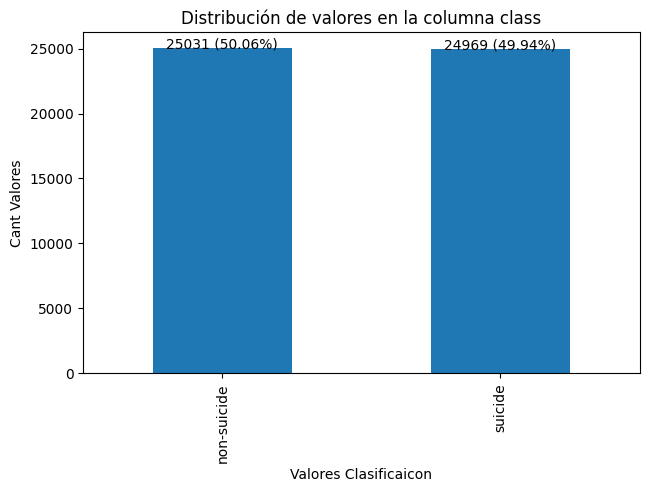

In [7]:
# Colocar el nombre de la columna para ver la distribucion de datos
show_dataset_info(dataframe, columna_clasificacion)

In [8]:
# Este caso puntual el csv local la primera columna es el indice que no nos interesa, si quiero eliminarla por el nombre que le asigna pandas
try:
    dataframe = dataframe.drop('Unnamed: 0', axis=1)
except:
    print("No se elimino columna Unnamed: 0")

# o eliminarla por la posicion
# dataframe = dataframe.drop(dataframe.columns[0], axis=1)

# Paso a booleano la clasificacion
dataframe[columna_clasificacion] = dataframe[columna_clasificacion].replace({"suicide": True, "non-suicide": False})
dataframe[columna_clasificacion].value_counts()

class
False    25031
True     24969
Name: count, dtype: int64

## Ajuste y guardado

In [9]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(dataframe[columna_texto],
                                                    dataframe[columna_clasificacion],
                                                    test_size=0.20, random_state=0,
                                                    stratify=dataframe[columna_clasificacion])

len(y_train), len(y_test)


# ----------------------------------------------------------------------
#BoW con vectores binarios. Estos se usaban en tareas de analisis de sentimientos que no necesita saber la cantidad de veces que se repite una palabra sino su mera presencia.
count_vectorizer = CountVectorizer(analyzer=preprocessing_function, binary=True)

# La idea es dado un texto hay que considerarlo una colección o bolsa (Bag) de palabras ignorando el orden y contexto.
# count_vectorizer = CountVectorizer(analyzer=preprocessing_function)

#Term Frecuency - Inverse Document Frecuency trata este tema calculando la importancia de una palabra en base a las otras en el documento y en el corpus.
# count_vectorizer = TfidfVectorizer(analyzer=preprocessing_function)

# ----------------------------------------------------------------------

X_train_vectorized = count_vectorizer.fit_transform(X_train)
X_test_vectorized = count_vectorizer.transform(X_test)

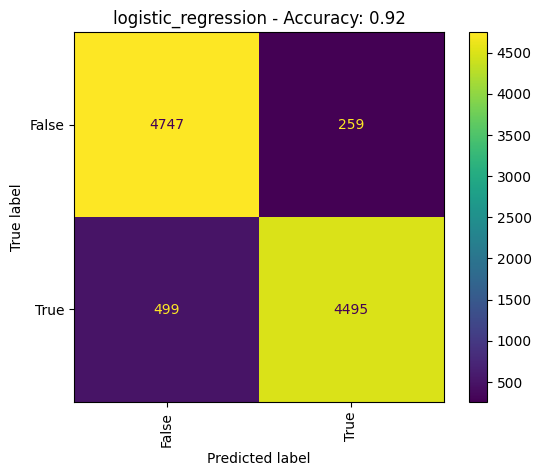

Modelo logistic_regression guardado en ..\entrenados\logistic_regression_50k
--------------------------------


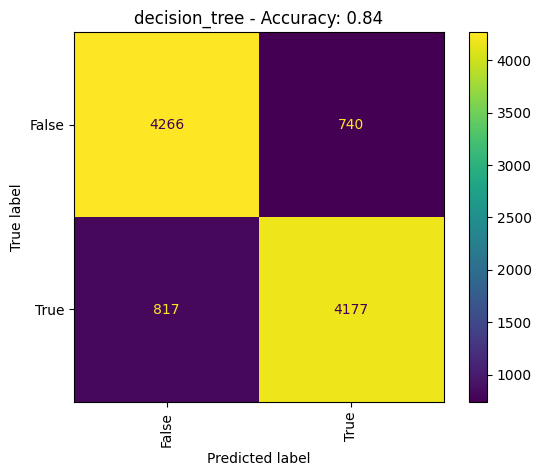

Modelo decision_tree guardado en ..\entrenados\decision_tree_50k
--------------------------------


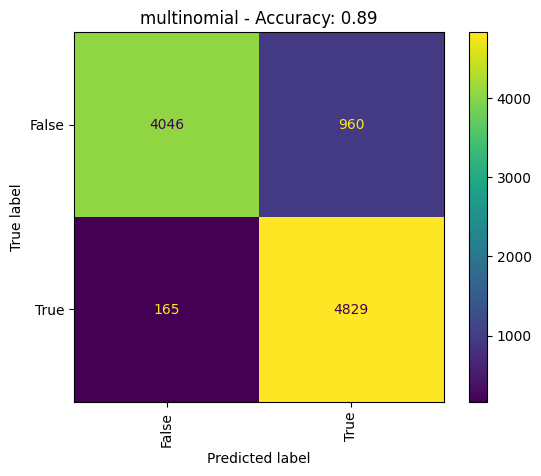

Modelo multinomial guardado en ..\entrenados\multinomial_50k
--------------------------------


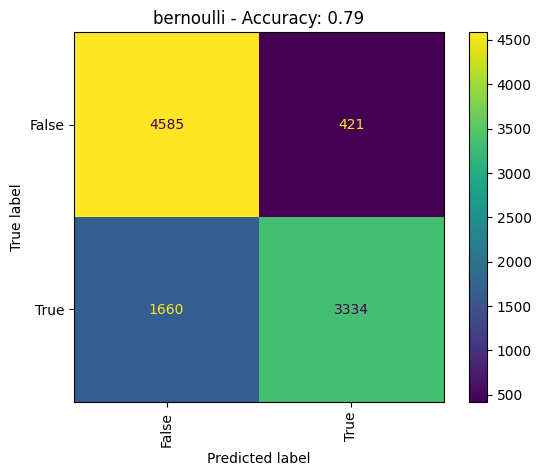

Modelo bernoulli guardado en ..\entrenados\bernoulli_50k
--------------------------------


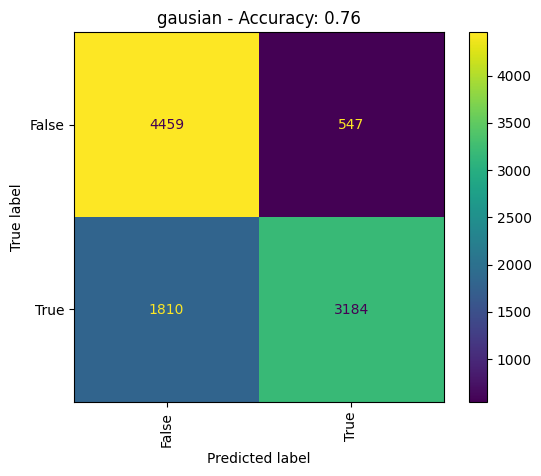

Modelo gausian guardado en ..\entrenados\gausian_50k
--------------------------------


In [10]:
# MODIFICAR ESTOS PARAMETROS PARA EL GUARDADO
# --------------------------------------------------------
# Colocar en true el modelo que se desea entrenar
modelos_disponibles = {
    Modelos.LOGISTIC_REGRESSION.value : True,
    Modelos.DECISION_TREE.value: True,
    Modelos.MULTINOMIAL.value: True,
    Modelos.BERNOULLI.value: True,
    Modelos.GAUSIAN.value: True,
}
path_base_modelo = '/content/' if is_running_on_colab() else '..\\entrenados\\'
# --------------------------------------------------------

cant_entrenada_str = "{:.0f}".format(cant_importada/1000) + 'k'

for nombreModelo, entrenar in modelos_disponibles.items():
    if entrenar:
        modelToTrain = select_model_to_train(nombreModelo)
        test(modelToTrain, nombreModelo)

        path_modelo = path_base_modelo + nombreModelo + '_' + cant_entrenada_str
        joblib.dump(modelToTrain, path_modelo +  '_model.pkl')
        joblib.dump(count_vectorizer, path_modelo + '_vector.pkl')
        print(f"Modelo {nombreModelo} guardado en " + path_modelo)
        modelToTrain = None
    else:
        print(f"Modelo {nombreModelo} no entrenado")
    print("--------------------------------")

# Casos de uso

## Cargar modelo previamente generado

EJECUTAR PREVIAMENTE Funcion procesador texto

In [11]:
# MODIFICAR ESTOS PARAMETROS PARA LA CARGA
# --------------------------------------------------------
nombre_modelo_prev_entrenado = Modelos.LOGISTIC_REGRESSION.value
# usar formato '25k' para 25.000 filas ejemplo
cant_prev_entrenada = '50k'

path_base_modelo_generado = '/content/' if is_running_on_colab() else '..\\entrenados\\'
path_modelo_generado = path_base_modelo_generado + nombre_modelo_prev_entrenado + '_' + cant_prev_entrenada
# --------------------------------------------------------

model = joblib.load(path_modelo_generado + '_model.pkl')
vect = joblib.load(path_modelo_generado + '_vector.pkl')

print(type(vect))
print(type(model))

<class 'sklearn.feature_extraction.text.CountVectorizer'>
<class 'sklearn.linear_model._logistic.LogisticRegression'>


## Probar con dataset

Cantidad de registros:
50000
Contenido:
   Unnamed: 0                                               text        class
0       74889  someone plz send me to horny jail 😹👍 i can’t f...  non-suicide
1       74891  Probably gonna get buried but idc &amp;#x200B;...  non-suicide
2       74892  What happens if you tell your psychiatrist you...      suicide
3       74895  I’m not like other girls... ...I’m a boy...\n\...  non-suicide
4       74896  So i dont have a phone and I need a verificati...  non-suicide


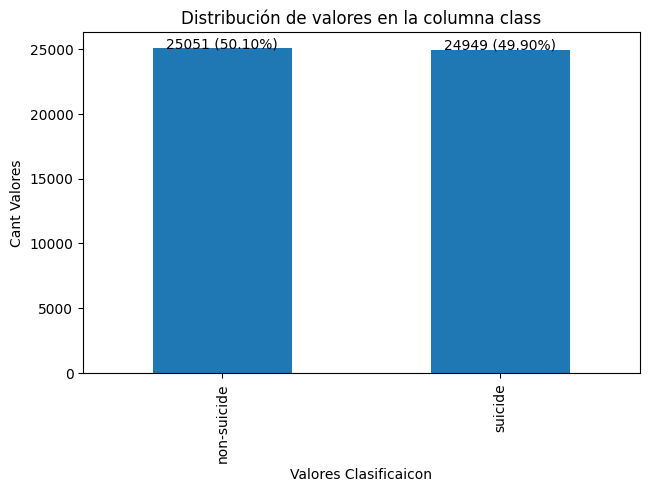

In [13]:

# MODIFICAR ESTOS PARAMETROS PARA LA CARGA
# --------------------------------------------------------
# 0 si se quiere arrancar desde el principio, en este caso ya se incluye el nombre de las columnas del csv
nro_fila_arranque = 50001
cant_a_probar = 50000

path_base_dataset_test = '/content/' if is_running_on_colab() else '..\\datasets\\'

nombre_archivo_dataset_test = 'Suicide_Detection.csv'
columna_texto_test = 'text'
columna_clasificacion_test = 'class'
clasificacion_true_test = 'suicide'
clasificacion_false_test = 'non-suicide'
# --------------------------------------------------------

path_dataset =  path_base_dataset_test + nombre_archivo_dataset_test
dataframeTest = pd.read_csv(path_dataset, skiprows=nro_fila_arranque, nrows=cant_a_probar)

columnas_renombradas = {columna_texto_test: 'text', columna_clasificacion_test: 'class'}

if nro_fila_arranque != 0:
    dataframeColumns = pd.read_csv(path_dataset, nrows=1).columns
    dataframeTest.columns = dataframeColumns

show_dataset_info(dataframeTest, columna_clasificacion_test)

In [14]:

counter = 0

for index, row in tqdm(dataframeTest.iterrows(), total=len(dataframeTest)):
    texto_test = row[columna_texto_test]
    clasificacion_test = True if row[columna_clasificacion_test] == clasificacion_true_test else False

    texto_preprocesado = ' '.join(preprocessing_function(texto_test))
    texto_vectorizado = vect.transform([texto_preprocesado])

    prediccion = model.predict(texto_vectorizado)[0]

    if prediccion != clasificacion_test:
        counter = counter + 1

print("La cantidad de casos donde no coincidio la prediccion con la clasificacion real del dataset: " + str(counter) + " - " + str("{:.2f} %".format(cant_a_probar / counter) if counter != 0 else "no hubo errores"))


100%|██████████| 50000/50000 [04:27<00:00, 186.89it/s]

La cantidad de casos donde no coincidio la prediccion con la clasificacion real del dataset: 4145 - 12.06 %


## Probar con nuestro datos

In [20]:
from googletrans import Translator

textos_prueba = [
                # "I want to jump from a bridge",
                # "I want to suicide me",
                #  "I hate my parents with all my heart",
                #  "I hate all about this life",
                #  "I cry every night",
                 "I don't know what is happen to me, but I don't want live anymore",
                 "Nose que me esta pasando, pero ya no quiero vivir mas",
                 "Non so cosa mi sta succedendo, ma non voglio più vivere."
                 ]

translator = Translator()

for texto in textos_prueba:
    texto_a_analizar = texto
    language = translator.detect(texto).lang

    if(language != 'en'):
        texto_a_analizar = translator.translate(texto, dest='en').text
        texto_esp = translator.translate(texto, dest='es').text
        
    texto_preprocesado = ' '.join(preprocessing_function(texto_a_analizar))
    texto_vectorizado = vect.transform([texto_preprocesado])

    prediccion = model.predict(texto_vectorizado)

    print('{0: <30}'.format('Texto original') + ': ' + texto)
    if(language not in 'es'):
        print('{0: <30}'.format('Texto traducido') + ': ' + texto_esp)
    print('{0: <30}'.format('Texto utilizado para predict') + ': ' + texto_a_analizar)
    print('------------------------------------------------------------------------------------------------------')


Texto original                : I don't know what is happen to me, but I don't want live anymore


NameError: name 'texto_esp' is not defined

# Palabras mas comunes segun mi funcion analizadora

In [21]:
#Usemos Lemmatization:
from collections import Counter

wnl = WordNetLemmatizer()

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]
    for word in preprocessing_function(text):
        word_counts[word] += 1

len(word_counts)

100%|██████████| 50000/50000 [02:30<00:00, 331.17it/s]


75854

In [22]:
word_counts.most_common(1000)

[('like', 40236),
 ('want', 39348),
 ('know', 32837),
 ('feel', 32630),
 ('life', 26791),
 ('think', 24457),
 ('go', 24016),
 ('time', 22173),
 ('fuck', 20616),
 ('people', 20486),
 ('get', 19463),
 ('year', 18696),
 ('friend', 17862),
 ('day', 17672),
 ('thing', 17410),
 ('try', 15610),
 ('tell', 14551),
 ('help', 14498),
 ('filler', 13499),
 ('good', 13078),
 ('talk', 12691),
 ('live', 11747),
 ('kill', 11737),
 ('end', 11452),
 ('bad', 11406),
 ('say', 11355),
 ('love', 11077),
 ('need', 11010),
 ('die', 10953),
 ('work', 10775),
 ('way', 10427),
 ('school', 10129),
 ('start', 9332),
 ('anymore', 9259),
 ('family', 8945),
 ('find', 8886),
 ('come', 8829),
 ('care', 8570),
 ('right', 7939),
 ('leave', 7783),
 ('suicide', 7713),
 ('look', 7595),
 ('shit', 7541),
 ('hate', 7444),
 ('well', 7350),
 ('make', 6871),
 ('post', 6869),
 ('stop', 6853),
 ('person', 6798),
 ('parent', 6759),
 ('long', 6576),
 ('take', 6524),
 ('month', 6478),
 ('job', 6476),
 ('point', 6399),
 ('thought', 6125

# Verificar ocurrencia de palabras

## Palabras mas comunes contando palabra por palabra

In [ ]:
# Intuición principal en este tipo de tecnicas: Contar las ocurrencias de las palabras.
from collections import defaultdict, Counter

# Instanciamos un contador de python
word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1]

    # Usamos la funcion implementada en pandas split() para separar palabras por espacios en blanco.
    for word in text.str.split()[0]:
        word_counts[word] += 1

len(word_counts)

In [ ]:
word_counts.most_common(25)

## Palabras mas comunes contando con tokenizador

In [ ]:
from nltk import word_tokenize

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]
    for word in word_tokenize(text):
        word_counts[word] += 1

len(word_counts)

In [ ]:
word_counts.most_common(25)

## Palabras mas comunes contando teniendo en cuenta stopwords

In [ ]:
stopwords_en = stopwords.words('english')
print(stopwords_en)

In [ ]:
from nltk.corpus import stopwords

stopwords_en = stopwords.words('english')

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()

        if word_lowercase not in stopwords_en:
            word_counts[word_lowercase] += 1

len(word_counts)

In [ ]:
word_counts.most_common(10)

## Palabras mas comunes contando teniendo en cuenta signos de puntuacion

In [ ]:
from string import punctuation

# Hacemos una union entre conjunto de caracteres de puntuacion nativos a nuestro conjunto de stopwords usando la operation union de sets de datos.
stopwords_en = set(stopwords_en).union(set(punctuation))

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()

        if word_lowercase not in stopwords_en:
            word_counts[word_lowercase] += 1

len(word_counts)

In [ ]:
word_counts.most_common(10)

## Stemming

In [ ]:
# Usamos Stemming
from nltk.stem import PorterStemmer

porter = PorterStemmer()

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word in word_tokenize(text):
        word_lowercase = word.lower()

        if word_lowercase not in stopwords_en:
            stemmed_word = porter.stem(word_lowercase)
            word_counts[stemmed_word] += 1

len(word_counts)

In [ ]:
word_counts.most_common(10)

## Lematization

In [ ]:
#Usemos Lemmatization:
from nltk import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer


wnl = WordNetLemmatizer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

word_counts = Counter()

for row in tqdm(dataframe.iterrows(), total=len(dataframe)):
    text = row[1].iat[0]

    for word, tag in pos_tag(word_tokenize(text)):
        word_lemmatized = wnl.lemmatize(word.lower(), pos=penn2morphy(tag))

        if word_lemmatized not in stopwords_en:
            word_counts[word_lemmatized] += 1

len(word_counts)